# Model for mixed-dimensional flow


In [1]:
import porepy as pp
import numpy as np

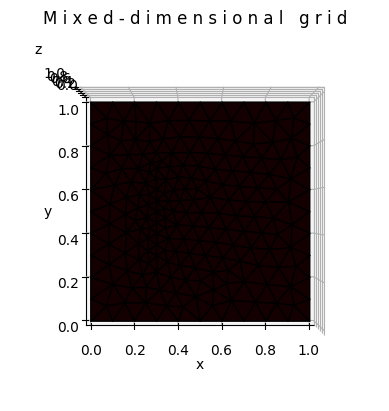

Bad pipe message: %s [b'"Chromium";v="110", "Not A(Brand";v="24", "Brave";v="110"']
Bad pipe message: %s [b'sec-ch-ua-mo']
Bad pipe message: %s [b'le: ?0\r\nsec-ch-ua-platform: "Windows"\r\nUpgrade-Insecure-Requests: 1\r\nUser-Agent: Mozilla/5.0 (Win', b'ws NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36\r\nAcce', b': text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8\r\nSec-GPC: 1\r']
Bad pipe message: %s [b'ol: max-age=0\r\nsec-ch-ua: "Chromium";v="110", "Not A(Brand";v="24", "Brave";v="110"\r\nsec-ch-ua-mobile: ?0\r\nsec-ch-u']
Bad pipe message: %s [b'platform: "Windows"\r\nUpgrade-Insecure-Requests: 1\r\nUser-Agent: Mozilla/5.0 (Windows NT 10.0; Win', b'; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/']
Bad pipe message: %s [b'ol: max-age=0\r\nsec-ch-ua: "Chromium";v="110", "Not A(Brand";v="24", "Brave";v="110"\r\nsec-ch-ua-mobile: ?0\r\nsec-ch-u']
Bad pipe message: %s [b'platform: "Window

In [4]:
pts = np.array([[0.3, 0.3], [0.3, 0.7]])
edges = np.array([[0], [1]])
domain = pp.Domain({'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1})
network = pp.FractureNetwork2d(pts=pts, edges=edges, domain=domain)
mdg = network.mesh(mesh_args={'mesh_size_min': 0.03, 'mesh_size_bound': 0.1, 'mesh_size_frac':0.05})
pp.plot_grid(mdg)

In [ ]:
pm